In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score

In [157]:
readfile=pd.read_csv("Country-data.csv",index_col=False)
file=pd.DataFrame(readfile)

In [158]:
df=file.copy()
df.drop(columns=['country'], inplace=True)

In [159]:
scaler = StandardScaler()
data = scaler.fit_transform(df)


In [160]:
class PCA():
    def __init__(self, variance):
        self.variance = variance

    def convert(self, data):
        cov_matrix = np.cov(data.T)
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        total_sum = np.sum(eigenvalues)

        cumulative_sum = 0
        percentages = []
        for percentage in (eigenvalues / total_sum * 100):
            cumulative_sum += percentage
            percentages.append(cumulative_sum)
            if cumulative_sum >= self.variance :
                break

        num_components = len(percentages)
        print(num_components)

        principal_components = eigenvectors[:, :num_components]

        reduced_data = np.dot(data, principal_components)
        plt.bar(np.arange(1, len(percentages) + 1), percentages, align='center', alpha=0.8)
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Percentage of Variance Explained')
        plt.title('Scree Plot (Bar Graph)')
        plt.show()

        return reduced_data

In [161]:
reducer = PCA(95)

6


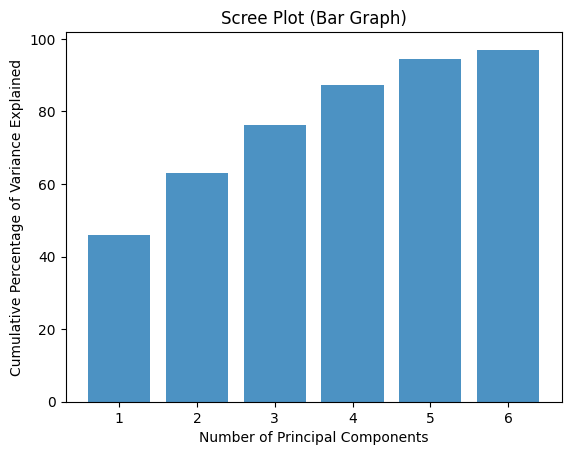

In [162]:
reduced_data=reducer.convert(data)

In [163]:
class KMeans:
    def __init__(self, k=3, max_iters=10000, tol=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.labels = None

    def kmeans_plusplus_init(self, X):
        self.centroids = [X[np.random.choice(X.shape[0])]]

        for _ in range(1, self.k):
            dist_sq = np.array([min([np.linalg.norm(c - x)**2 for c in self.centroids]) for x in X])
            probs = dist_sq / dist_sq.sum()
            cumprobs = probs.cumsum()
            r = np.random.rand()
            for j, p in enumerate(cumprobs):
                if r < p:
                    i = j
                    break
            self.centroids.append(X[i])

        self.centroids = np.array(self.centroids)

    def classify(self, X):
        self.kmeans_plusplus_init(X)

        for iter in range(self.max_iters):
            
            self.labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2), axis=1)
            
            new_centroids = np.array([X[self.labels == j].mean(axis=0) for j in range(self.k)])

            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break

            self.centroids = new_centroids

        return self.labels

    def silhouette_score(self, X):
        if self.labels is None:
            raise ValueError("KMeans has not been fitted. Call the classify method first.")
        return silhouette_score(X, self.labels)
    
    def inertia(self, X):
        if self.centroids is None:
            raise ValueError("Centroids not initialized. Call classify() or kmeans_plusplus_init() first.")

        distances = np.array([np.linalg.norm(X[i] - self.centroids[self.labels[i]])**2 for i in range(len(X))])
        return np.sum(distances)

In [164]:
model_PCA=KMeans()
labels_PCA=model_PCA.classify(reduced_data)
print(model_PCA.silhouette_score(reduced_data))
print(model_PCA.inertia(reduced_data))

0.2993048365115851
786.8230037289771


In [165]:
model_raw=KMeans()
labels_raw=model_raw.classify(df.values)
print(model_raw.silhouette_score(df.values))
print(model_raw.inertia(df.values))

0.7106457354531156
22336241763.973698


In [166]:
df['label']=labels_PCA
cluster_mean = df.groupby('label')['child_mort'].mean()
ordered_clusters = cluster_mean.sort_values().index
label_mapping = {label: category for label, category in zip(ordered_clusters, ['Developed', 'Developing', 'Underdeveloped'])}
df['class']= file['class'] = df['label'].map(label_mapping)


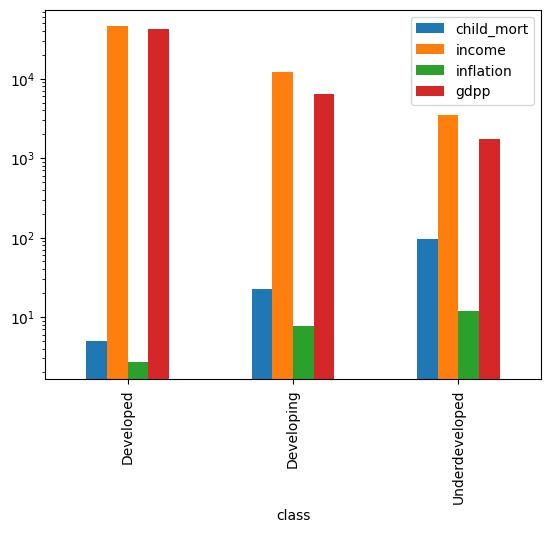

In [167]:
cluster_mean = df.groupby(by = 'class').mean()
cluster_mean[['child_mort','income','inflation','gdpp']].plot.bar()
plt.yscale('log')
plt.show()

In [168]:
cluster = file.groupby('class')
for label, cluster in cluster:
    print(f"Countries in Cluster {label}:")
    print(cluster['country'].values)

Countries in Cluster Developed:
['Australia' 'Austria' 'Bahrain' 'Belgium' 'Brunei' 'Canada' 'Cyprus'
 'Czech Republic' 'Denmark' 'Finland' 'France' 'Germany' 'Greece'
 'Iceland' 'Ireland' 'Israel' 'Italy' 'Japan' 'Kuwait' 'Luxembourg'
 'Malta' 'Netherlands' 'New Zealand' 'Norway' 'Portugal' 'Qatar'
 'Singapore' 'Slovak Republic' 'Slovenia' 'South Korea' 'Spain' 'Sweden'
 'Switzerland' 'United Arab Emirates' 'United Kingdom' 'United States']
Countries in Cluster Developing:
['Albania' 'Algeria' 'Antigua and Barbuda' 'Argentina' 'Armenia'
 'Azerbaijan' 'Bahamas' 'Bangladesh' 'Barbados' 'Belarus' 'Belize'
 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brazil'
 'Bulgaria' 'Cambodia' 'Cape Verde' 'Chile' 'China' 'Colombia'
 'Costa Rica' 'Croatia' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Estonia' 'Fiji' 'Georgia' 'Grenada' 'Guatemala' 'Guyana'
 'Hungary' 'India' 'Indonesia' 'Iran' 'Iraq' 'Jamaica' 'Jordan'
 'Kazakhstan' 'Kyrgyz Republic' 'Latvia' 'Lebanon' 'Libya' 'L